In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('dark_background')


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense, GRU
from keras.callbacks import ModelCheckpoint

# Eval Function

In [ ]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
def train_test_valid(data):
  train_size = int(0.7 * len(data))
  test_size = int(0.2 * len(data))
  val_size = len(data) - train_size - test_size

  train_data = data[:train_size]
  test_data = data[train_size:train_size+test_size]
  valid_data = data[train_size+test_size:]

  return train_data, test_data, valid_data, train_size, test_size, val_size

# HoaPhat_HPG

## Data

In [ ]:
df_amz = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/HoaPhat_HPG_y_m_d.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,10260.39,10443.02,10227.19,10227.19,10227.19,12637219.0
1,2019-01-03,10210.59,10260.39,9795.52,9795.52,9795.52,21178963.0
2,2019-01-04,9762.32,9961.55,9529.88,9861.93,9861.93,20085098.0
3,2019-01-07,10061.16,10077.77,9679.30,9745.71,9745.71,7495579.0
4,2019-01-08,9762.32,9795.52,9529.88,9579.69,9579.69,12767952.0
...,...,...,...,...,...,...,...
1537,2025-03-06,27600.00,27950.00,27600.00,27950.00,27950.00,37159600.0
1538,2025-03-07,28000.00,28100.00,27750.00,28050.00,28050.00,33131210.0
1539,2025-03-10,28100.00,28200.00,27950.00,27950.00,27950.00,23863520.0
1540,2025-03-11,27600.00,28150.00,27600.00,28150.00,28150.00,26088500.0


## Preprocessing

### Check null and na value

In [ ]:
df_amz.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_amz.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format & reset index

In [ ]:
df_amz = df_amz.set_index(pd.DatetimeIndex(df_amz['Date'].values))

df_amz.index = pd.to_datetime(df_amz.index,format='%Y-%m-%d')

close_amz = pd.DataFrame(df_amz, columns=['Date', 'Close'])
close_amz.drop('Date', axis = 1, inplace = True)

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])

Starting date:  2019-01-02
Ending date:  2025-03-12


<ipython-input-10-f85b7d6a4d52>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_amz.iloc[0][0])
<ipython-input-10-f85b7d6a4d52>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_amz.iloc[-1][0])


### Visualize the per day closing price of the stock

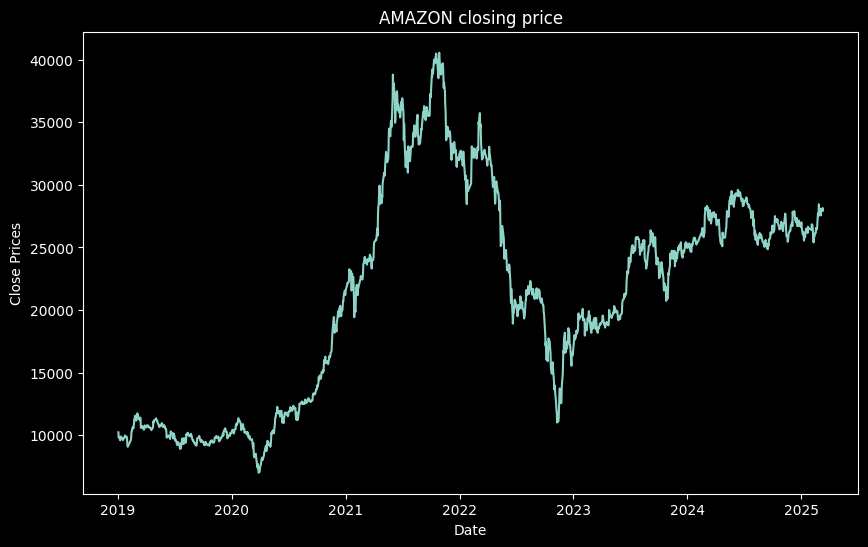

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_amz['Close'])
plt.title('AMAZON closing price')
plt.show()

## Train, test, valid

In [ ]:
data_amz = close_amz.values
scaler = MinMaxScaler(feature_range=(0, 1))

sc_train = scaler.fit_transform(data_amz)

train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(sc_train)

In [ ]:
x_train, y_train = [], []

for i in range(100, len(train_data)):
    x_train.append(sc_train[i-100:i, 0])
    y_train.append(sc_train[i, 0])

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

## Build & train model

In [ ]:
model = Sequential()

model.add(GRU(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(GRU(50,return_sequences=True))
model.add(GRU(50))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = '/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_HoaPhat_HPG_721.keras'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80

Epoch 1: loss improved from inf to 0.13602, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_HoaPhat_HPG_721.keras
20/20 - 10s - 478ms/step - loss: 0.1360
Epoch 2/80

Epoch 2: loss improved from 0.13602 to 0.03217, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_HoaPhat_HPG_721.keras
20/20 - 5s - 260ms/step - loss: 0.0322
Epoch 3/80

Epoch 3: loss improved from 0.03217 to 0.02013, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_HoaPhat_HPG_721.keras
20/20 - 9s - 434ms/step - loss: 0.0201
Epoch 4/80

Epoch 4: loss improved from 0.02013 to 0.01734, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_HoaPhat_HPG_721.keras
20/20 - 5s - 250ms/step - loss: 0.0173
Epoch 5/80

Epoch 5: loss did not improve from 0.01734
20/20 - 4s - 187ms/step - loss: 0.0185
Epoch 6/80

Epoch 6: loss did not improve from 0.01734
20/20 - 5s - 252ms

## Eval

In [ ]:
y_train = scaler.inverse_transform(y_train)

final_model = load_model('/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_HoaPhat_HPG_721.keras')

y_train_predict = final_model.predict(x_train)

y_train_predict = scaler.inverse_transform(y_train_predict)

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step


In [ ]:
test = close_amz[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = scaler.transform(test)

x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test = data_amz[train_size:train_size+test_size]  # True values

y_test_predict = final_model.predict(x_test)

y_test_predict = scaler.inverse_transform(y_test_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:
val = close_amz[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = scaler.transform(val)

x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

y_val = data_amz[train_size+test_size:]  # True values

y_val_predict = final_model.predict(x_val)

y_val_predict = scaler.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
train_data = close_amz[:train_size]
test_data = close_amz[train_size:train_size+test_size]
val_data = close_amz[train_size+test_size:]

In [ ]:
eval(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  328.2365269886363
MAPE:  1.31900529192422
RMSE:  432.48716796052076

** Validate **
MAE:  317.66089969758065
MAPE:  1.1980606305749548
RMSE:  399.8980163448646


## Predict

In [ ]:
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)
print(x_input.shape)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(temp_input)

(1, 100)
[0.5975312239043593, 0.6005103908875624, 0.5990208073959609, 0.6034895578707655, 0.594552056921156, 0.5885937229547498, 0.5856145559715467, 0.5796562220051402, 0.5796562220051402, 0.5796562220051402, 0.5885937229547498, 0.5975312239043593, 0.5930624734295544, 0.5826353889883433, 0.5751874715303356, 0.594552056921156, 0.594552056921156, 0.5960416404127575, 0.6168958092951797, 0.6109374753287735, 0.5975312239043593, 0.5751874715303356, 0.5632708035975229, 0.5602916366143198, 0.5498645521731087, 0.5543333026479134, 0.5617812201059214, 0.5692291375639291, 0.5751874715303356, 0.5766770550219371, 0.5751874715303356, 0.5781666385135387, 0.5885937229547498, 0.5930624734295544, 0.5960416404127575, 0.5871041394631482, 0.6213645597699844, 0.6139166423119766, 0.6154062258035782, 0.622854143261586, 0.6183853927867813, 0.6109374753287735, 0.601999974379164, 0.5960416404127575, 0.5960416404127575, 0.6064687248539686, 0.5915728899379529, 0.5871041394631482, 0.5960416404127575, 0.5871041394631

In [ ]:
lst_output = []
n_steps = 100
i = 0

while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

[[0.6412221789360046], [0.6600368022918701], [0.6776564121246338], [0.6948713660240173], [0.7124367952346802], [0.730574905872345], [0.7492875456809998], [0.768532395362854], [0.7882669568061829], [0.8084492683410645], [0.8290344476699829], [0.8499715924263], [0.8712037205696106], [0.892667293548584], [0.9142928719520569], [0.9360048770904541], [0.9577234387397766], [0.9793647527694702], [1.000841736793518], [1.0220662355422974], [1.0429500341415405], [1.0634071826934814], [1.0833543539047241], [1.1027134656906128], [1.121413230895996], [1.139390230178833], [1.1565895080566406], [1.172966480255127], [1.1884863376617432], [1.2031242847442627]]


In [ ]:
datelist_train = df_amz['Date'].astype(str).tolist()

datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

print(y_pred_future)

[[28516.5493837 ]
 [29148.08912155]
 [29739.51652163]
 [30317.36106665]
 [30906.96981667]
 [31515.80143772]
 [32143.91795197]
 [32789.89885168]
 [33452.31762695]
 [34129.76577432]
 [34820.7367553 ]
 [35523.52195917]
 [36236.20870224]
 [36956.66422219]
 [37682.55768588]
 [38411.35218652]
 [39140.36676582]
 [39866.7884183 ]
 [40587.69409916]
 [41300.12475069]
 [42001.11931451]
 [42687.79275938]
 [43357.34808554]
 [44007.16435616]
 [44634.84871594]
 [45238.27240398]
 [45815.59076092]
 [46365.30725183]
 [46886.25345908]
 [47377.59708517]]


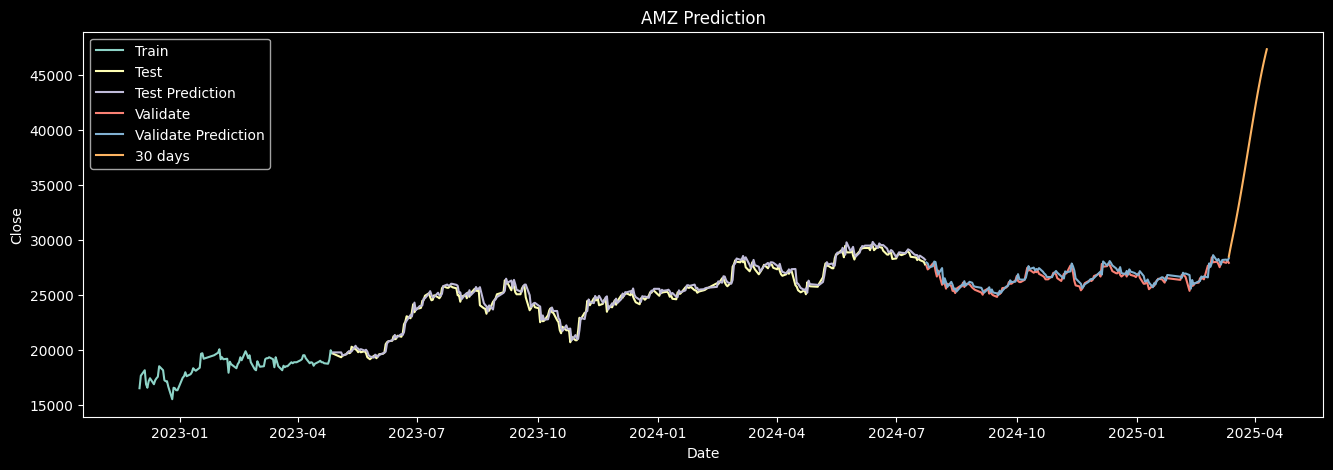

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))

plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('AMZ Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction','30 days'])
plt.show()

# NamKim_NKG

## Data

In [ ]:
df_tsla = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/NamKim_NKG_y_m_d.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,4565.97,4577.55,4403.94,4403.94,4403.94,65576.0
1,2019-01-03,4403.94,4496.53,4195.60,4195.60,4195.60,559110.0
2,2019-01-04,4195.60,4195.60,3946.76,4079.86,4079.86,116707.0
3,2019-01-07,4079.86,4224.54,4079.86,4079.86,4079.86,132570.0
4,2019-01-08,4079.86,4155.09,4056.71,4079.86,4079.86,137979.0
...,...,...,...,...,...,...,...
1540,2025-03-06,15550.00,16100.00,15500.00,16100.00,16100.00,14202800.0
1541,2025-03-07,16050.00,16300.00,15900.00,16100.00,16100.00,10169700.0
1542,2025-03-10,16150.00,16200.00,15700.00,15800.00,15800.00,9795200.0
1543,2025-03-11,15500.00,16100.00,15400.00,16100.00,16100.00,14542500.0


## Preprocessing

### Check null and na value

In [ ]:
df_tsla.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_tsla.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])

Starting date:  2019-01-02
Ending date:  2025-03-12


<ipython-input-32-1625b6c5d97d>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_tsla.iloc[0][0])
<ipython-input-32-1625b6c5d97d>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_tsla.iloc[-1][0])


### Visualize the per day closing price of the stock

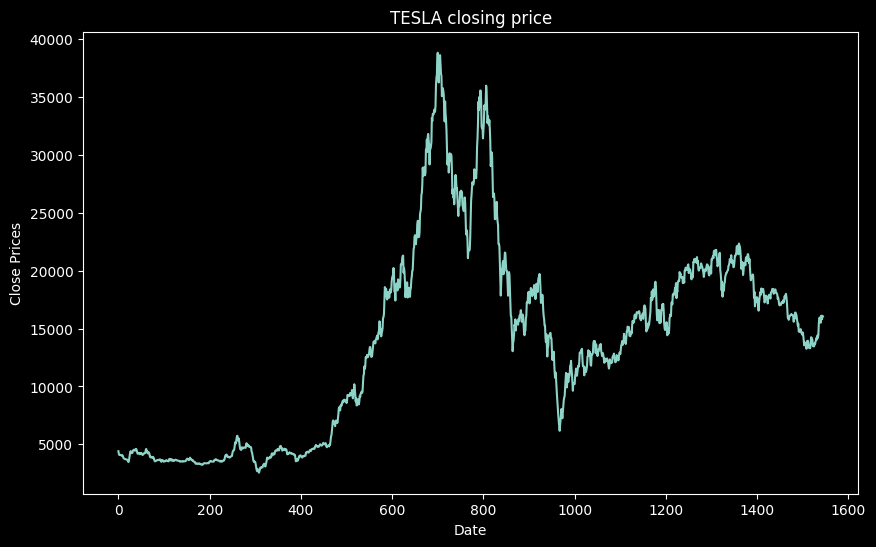

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_tsla['Close'])
plt.title('TESLA closing price')
plt.show()

## Train, test, valid

### Convert date from string to date format & reset index

In [ ]:
df_tsla = df_tsla.set_index(pd.DatetimeIndex(df_tsla['Date'].values))

df_tsla.index = pd.to_datetime(df_tsla.index,format='%Y-%m-%d')

close_tsla = pd.DataFrame(df_tsla, columns=['Date', 'Close'])
close_tsla.drop('Date', axis = 1, inplace = True)

### Split

In [ ]:
data_tsla = close_tsla.values
scaler = MinMaxScaler(feature_range=(0, 1))

sc_train = scaler.fit_transform(data_tsla)

train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(sc_train)

In [ ]:
x_train, y_train = [], []

for i in range(100, len(train_data)):
    x_train.append(sc_train[i-100:i, 0])
    y_train.append(sc_train[i, 0])

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

## Build model

In [ ]:
model = Sequential()

model.add(GRU(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(GRU(50,return_sequences=True))
model.add(GRU(50))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = '/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_NamKim_NKG_721.keras'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.08889, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_NamKim_NKG_721.keras
20/20 - 11s - 561ms/step - loss: 0.0889
Epoch 2/80

Epoch 2: loss improved from 0.08889 to 0.02614, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_NamKim_NKG_721.keras
20/20 - 4s - 204ms/step - loss: 0.0261
Epoch 3/80

Epoch 3: loss improved from 0.02614 to 0.01979, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_NamKim_NKG_721.keras
20/20 - 6s - 286ms/step - loss: 0.0198
Epoch 4/80

Epoch 4: loss improved from 0.01979 to 0.01692, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_NamKim_NKG_721.keras
20/20 - 5s - 244ms/step - loss: 0.0169
Epoch 5/80

Epoch 5: loss improved from 0.01692 to 0.01564, saving model to /content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_NamKim_NKG_721.keras
20/20 - 5s - 

## Eval

In [ ]:
y_train = scaler.inverse_transform(y_train)

final_model = load_model('/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Model/GRU_NamKim_NKG_721.keras')

y_train_predict = final_model.predict(x_train)

y_train_predict = scaler.inverse_transform(y_train_predict)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


In [ ]:
test = close_tsla[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = scaler.transform(test)

x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test = data_tsla[train_size:train_size+test_size]  # True values

y_test_predict = final_model.predict(x_test)

y_test_predict = scaler.inverse_transform(y_test_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [ ]:
val = close_tsla[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = scaler.transform(val)

x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

y_val = data_tsla[train_size+test_size:]  # True values

y_val_predict = final_model.predict(x_val)

y_val_predict = scaler.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [ ]:
train_data = close_tsla[:train_size]
test_data = close_tsla[train_size:train_size+test_size]
val_data = close_tsla[train_size+test_size:]

In [ ]:
eval(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  504.90884430622987
MAPE:  2.8080433551931567
RMSE:  619.9883795124566

** Validate **
MAE:  452.654436995968
MAPE:  2.7950632007467053
RMSE:  534.1696558187947


## Predict

In [ ]:
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)
print(x_input.shape)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(temp_input)

(1, 100)
[0.4134013726406447, 0.4168474477678393, 0.40995529751345006, 0.40076558005025764, 0.3984682885274646, 0.39961707213186615, 0.39961707213186615, 0.39961707213186615, 0.40536043878185385, 0.4065092223862554, 0.4042116551774523, 0.4042116551774523, 0.41110380543184155, 0.40536043878185385, 0.40995529751345006, 0.4202935228950339, 0.4168474477678393, 0.42259081441782703, 0.42603688954502167, 0.4179959556862308, 0.4065092223862554, 0.3858327716230876, 0.3686023959871145, 0.3697509039055059, 0.36400753725551827, 0.3686023959871145, 0.37319697903270055, 0.3743457626371021, 0.3743457626371021, 0.3766430541598952, 0.37779183776429676, 0.37549454624150375, 0.37549454624150375, 0.37549454624150375, 0.37089968750990754, 0.359412678523922, 0.37319697903270055, 0.3663048287783113, 0.3812379128914914, 0.3812379128914914, 0.37779183776429676, 0.37549454624150375, 0.3663048287783113, 0.359412678523922, 0.3502232367467397, 0.3548180954783359, 0.3364389362379612, 0.3364389362379612, 0.335060506

In [ ]:
lst_output = []
n_steps = 100
i = 0

while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

[[0.3709336519241333], [0.3691597580909729], [0.3674662411212921], [0.36577409505844116], [0.3640451431274414], [0.3622756004333496], [0.3604711592197418], [0.35863742232322693], [0.3567792475223541], [0.35490068793296814], [0.35300543904304504], [0.35109707713127136], [0.3491784632205963], [0.3472525477409363], [0.3453216552734375], [0.3433879315853119], [0.34145334362983704], [0.3395194113254547], [0.3375876247882843], [0.3356592059135437], [0.33373525738716125], [0.33181658387184143], [0.3299040198326111], [0.3279982805252075], [0.32609984278678894], [0.32420915365219116], [0.3223266303539276], [0.32045257091522217], [0.3185873329639435], [0.31673097610473633]]


In [ ]:
datelist_train = df_tsla['Date'].astype(str).tolist()

datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

print(y_pred_future)

[[16001.23199629]
 [15936.8872792 ]
 [15875.45808413]
 [15814.07861617]
 [15751.36408343]
 [15687.17719586]
 [15621.72442905]
 [15555.20901554]
 [15487.80716227]
 [15419.6658885 ]
 [15350.91924122]
 [15281.69694334]
 [15212.10277317]
 [15142.24375209]
 [15072.20419998]
 [15002.06195058]
 [14931.88835149]
 [14861.73853492]
 [14791.66655209]
 [14721.71672498]
 [14651.92905149]
 [14582.33271927]
 [14512.95799699]
 [14443.83082923]
 [14374.96851238]
 [14306.3872618 ]
 [14238.10221182]
 [14170.12417269]
 [14102.4661167 ]
 [14035.13020589]]


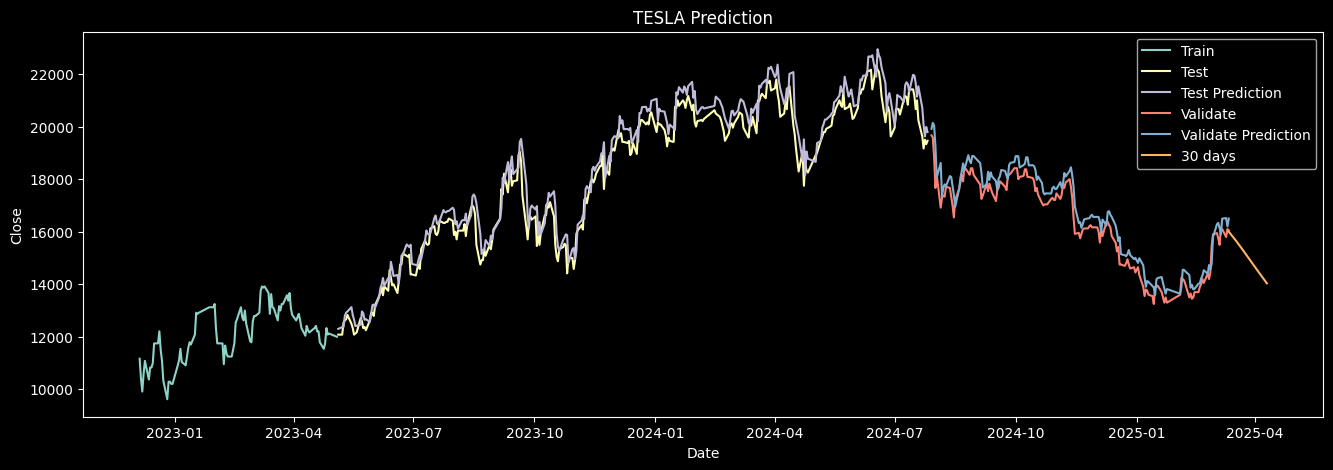

In [ ]:
y_pred_future = scaler.inverse_transform(lst_output)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))

plt.figure(figsize=(16,5))

plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('TESLA Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction','30 days'])
plt.show()